!pip install opencv-python pixellib

In [2]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.11.0


두 장의 이미지를 읽어서 -> RGB로 변환 -> 크기 출력 -> 화면에 나란히 보여주는 OpenCV+Matplotlib 파이프라인 코드

원본 고양이 이미지 크기: (654, 981, 3)
배경(사막) 이미지 크기: (1432, 2194, 3)


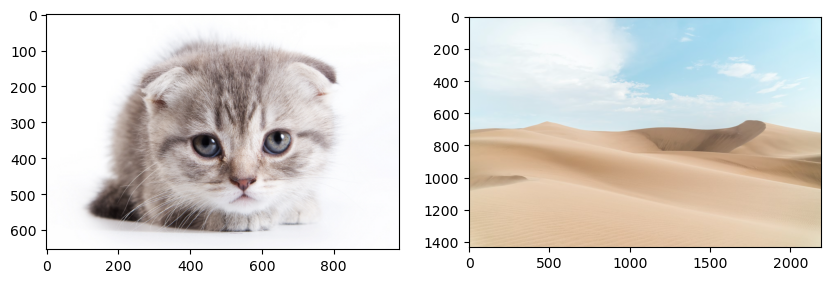

In [7]:
# 이미지 파일 경로 지정
cat_img_path = "cat.jpg"
sand_img_path = "sand.jpg"

# OpenCV로 이미지 읽기
cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

# BGR -> RGB 색상 변환
cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

# 이미지 크기 출력
print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

# 시각화 준비
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)   # 첫 번째 이미지 (고양이)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)   # 두 번째 이미지 (사막 배경)
plt.imshow(sand_img)

# 화면에 실제 보여주기
plt.show()

DeepLabV3로 이미지를 의미 분할(semantic segmentation)해서 “마스크”를 얻는 코드

In [9]:
# 사전학습된 분할 모델 불러오기
model = deeplabv3_resnet101(pretrained=True).eval()

# 입력 이미지 전처리 파이프라인
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 크기를 모델이 학습된 스케일에 맞춤
    T.ToTensor(),
])

# 배치 차원 추가 -> 모델은 항상 여러 입력 묶음(batch) 형태로 계산하도록 설계되어 있어서, 이미지 1장도 1장짜리 배치로 만들어줘야 함.
input_tensor = transform(cat_img).unsqueeze(0)

# 추론 시 그래디언트 끄기 -> 학습이 아니라 결과만 필요하므로, 불필요한 그래디언트 계산을 막아 메모리와 연산을 절약하기 위함.
# 그래디언트란? 학습 시 필요한 정보로 "이 파라미터를 얼마나 바꿔야 하나"를 계산하기 위해 사용
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 모델 추론
print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

추론 마스크 크기 (Before Resize): (520, 520)


In [10]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (654, 981)


In [12]:
# 이미지에 실제로 예측된 클래스 ID 목록을 뽑는 코드
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [0 8]


분할 결과에서 하나의 클래스만 골라서 흑백 마스크로 만드는 과정 코드

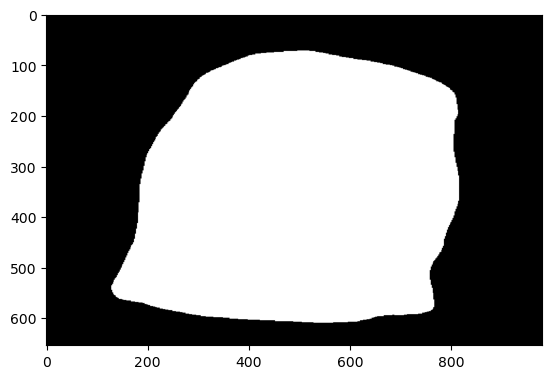

In [13]:
# 예측된 클래스 ID들 중 가장 큰 값 하나를 대상 클래스로 선택
target_class_id = unique_classes[-1]

# 분할 결과에서 대상 클래스인 픽셀만 True로 표시한 불리언 마스크 생성
seg_map = (output_predictions_resized == target_class_id)
# 불리언 마스크를 흑백(0/255) 이미지 마스크로 변환
img_mask = seg_map.astype(np.uint8) * 255

# 생성된 마스크를 회색조 이미지로 시각화
plt.imshow(img_mask, cmap='gray')
plt.show()

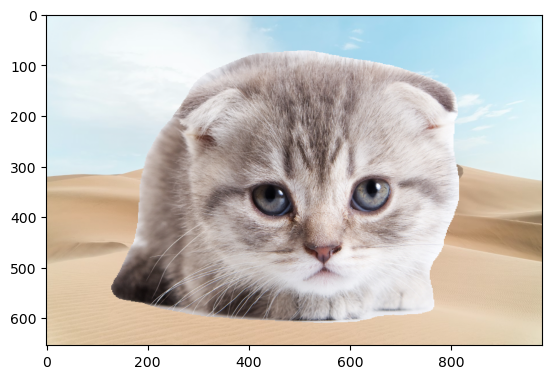

In [15]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

## Step 3. 해결 방법 제안

본 프로젝트에서는 Semantic Segmentation 기반으로 인물(동물) 모드 사진을 제작하였다. DeepLabV3 모델을 활용해 피사체 영역을 분리하고, 배경에 아웃포커싱 및 배경 전환 효과를 적용하였다. 기본적인 인물모드 효과는 구현할 수 있었으나, 결과물을 분석한 결과 실제 상용 카메라 수준에는 미치지 못하는 몇 가지 문제점이 확인되었다.

### 1. 제작한 인물모드 사진의 문제점

첫째, 피사체와 배경의 경계가 부자연스럽다.
고양이의 귀나 얼굴 윤곽, 털과 같은 미세한 영역에서 segmentation mask가 정확하지 않아 경계가 딱딱하게 잘린 듯한 느낌을 준다. 이는 실제 카메라의 얕은 피사계 심도에서 나타나는 자연스러운 흐림과 차이가 있다.

둘째, 피사계심도(depth, 카메라에서 초점이 맞아 선명하게 보이는 거리 범위)를 고려하지 못한다.
Semantic segmentation 결과는 각 픽셀이 어떤 클래스에 속하는지만 판단할 뿐, 피사체와 카메라 사이의 거리 정보는 포함하지 않는다. 그 결과 피사체 내부에서도 모든 영역이 동일하게 선명하게 처리되고, 배경은 거리와 무관하게 일괄적으로 흐려져 실제 광학적 아웃포커싱과 차이가 발생한다.

셋째, 배경 합성 시 공간적 이질감이 발생한다.
배경 전환 과정에서 피사체가 배경 위에 평면적으로 붙어 있는 듯한 인상을 주며, 이는 2D segmentation 결과만을 이용한 합성의 한계로 볼 수 있다.

이러한 문제의 공통적인 원인은 Semantic Segmentation이 2D 픽셀 분류에 기반한 기술이라는 점에 있다. 즉, “무엇인지”는 알 수 있지만 “얼마나 떨어져 있는지”에 대한 정보가 없어 실제 카메라의 피사계심도를 충실히 재현하지 못한다.

### 2. 해결 방법 제안: Depth Estimation과 Semantic Segmentation의 결합

위 문제를 해결하기 위한 핵심적인 방법으로 Depth Estimation(깊이 추정) 기술을 Semantic Segmentation과 결합하는 방안을 제안한다.

Depth Estimation 모델은 단일 이미지 또는 다중 이미지로부터 각 픽셀의 상대적인 거리(depth map)를 추정한다. 이 depth map을 segmentation mask와 함께 활용하면, 기존 mask 기반 인물모드의 한계를 보완할 수 있다.

적용 메커니즘

Semantic Segmentation 수행
DeepLabV3 모델을 사용해 피사체(인물 또는 동물) 영역을 분리하고 1차 mask를 생성한다. 이 단계에서는 “피사체인지 배경인지”를 판단한다.

Depth Estimation 수행
동일한 입력 이미지에 대해 depth estimation 모델을 적용하여 각 픽셀의 상대적인 거리 정보를 담은 depth map을 생성한다. 이를 통해 피사체와 배경, 그리고 피사체 내부의 거리 차이를 파악할 수 있다.

Mask와 Depth Map 결합
Segmentation mask의 경계 영역에서 depth 정보를 함께 고려한다. 예를 들어, 피사체 경계에서 depth 값이 급격히 변하는 영역은 부드럽게 처리하여 경계가 자연스럽게 블렌딩되도록 한다.

Depth 기반 아웃포커싱 적용
배경 전체를 동일하게 blur 처리하는 대신, depth 값에 따라 blur 강도를 조절한다. 카메라로부터 멀어질수록 더 강한 흐림을 적용함으로써 실제 광학적 피사계 심도에 가까운 효과를 구현할 수 있다.

기대 효과

이와 같은 방식은 기존 Semantic Segmentation만 사용했을 때 발생하던 경계의 거칠음과 평면적인 합성 문제를 완화할 수 있다. 또한 거리 정보를 기반으로 한 점진적인 아웃포커싱을 통해, 보다 자연스럽고 현실감 있는 인물모드 사진을 생성할 수 있다.

### 3. 정리

본 프로젝트에서 제작한 인물모드 사진은 기본적인 기능은 구현되었으나, Semantic Segmentation의 구조적 한계로 인해 경계 처리와 피사계심도 표현에서 문제점이 나타났다. 이를 해결하기 위해 Depth Estimation을 결합하는 방법을 제안하였으며, 이 방식은 segmentation mask의 오류를 보완하고 실제 카메라에 가까운 인물모드 효과를 구현하는 데 효과적인 해결책이 될 수 있다.

### (1) 아웃포커싱 효과가 적용된 인물모드 사진 1장
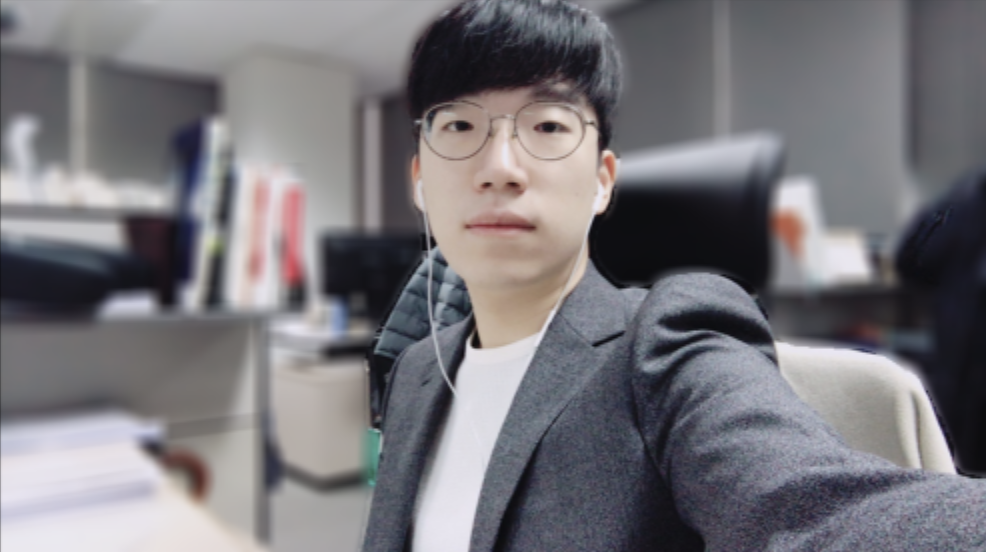

### (1-1) Semantic Segmentation 기반 크로마키(배경전환) 결과

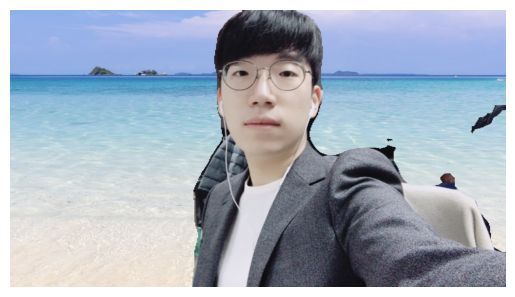

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101

# 1) 모델 로드
model = deeplabv3_resnet101(pretrained=True).eval()

# 2) 전처리
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),
    T.ToTensor(),
])

# 3) 경로
person_path = "person.jpg"   # 인물 사진
bg_path     = "new_bg.jpg"   # 바다 배경

# 4) 이미지 로드
person_bgr = cv2.imread(person_path)
bg_bgr     = cv2.imread(bg_path)

if person_bgr is None: raise FileNotFoundError(f"인물 이미지 로드 실패: {person_path}")
if bg_bgr is None:     raise FileNotFoundError(f"배경 이미지 로드 실패: {bg_path}")

person_rgb = cv2.cvtColor(person_bgr, cv2.COLOR_BGR2RGB)
bg_rgb     = cv2.cvtColor(bg_bgr, cv2.COLOR_BGR2RGB)

# 5) 세그멘테이션 추론
input_tensor = transform(person_rgb).unsqueeze(0)
with torch.no_grad():
    out = model(input_tensor)["out"][0]
pred = out.argmax(0).byte().cpu().numpy()

# 6) 사람 클래스(person=15)
person_id = 15
mask_520 = (pred == person_id).astype(np.uint8) * 255

# 7) 원본 크기로 리사이즈
H, W = person_rgb.shape[:2]
mask = cv2.resize(mask_520, (W, H), interpolation=cv2.INTER_NEAREST)
bg_resized = cv2.resize(bg_rgb, (W, H), interpolation=cv2.INTER_LINEAR)

# 8) 합성 (노드3,4 스타일)
mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
result = np.where(mask_color == 255, person_rgb, bg_resized)

# 9) 출력
plt.imshow(result)
plt.axis("off")
plt.show()

### (2) 아웃포커싱 효과가 적용된 동물 사진 1장
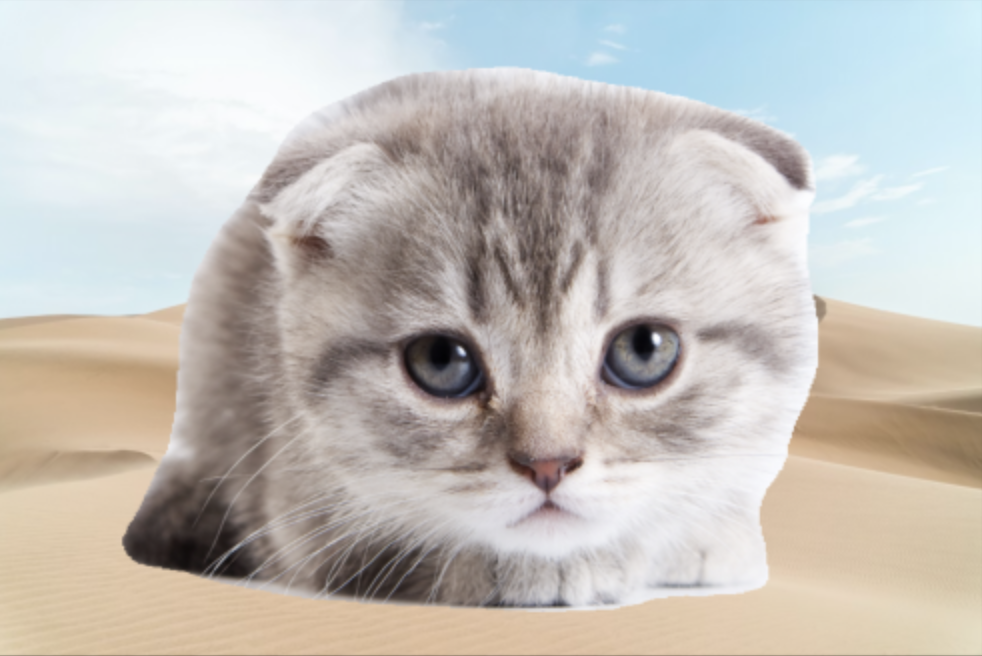

### (2-1) Semantic Segmentation 기반 크로마키(배경전환) 결과

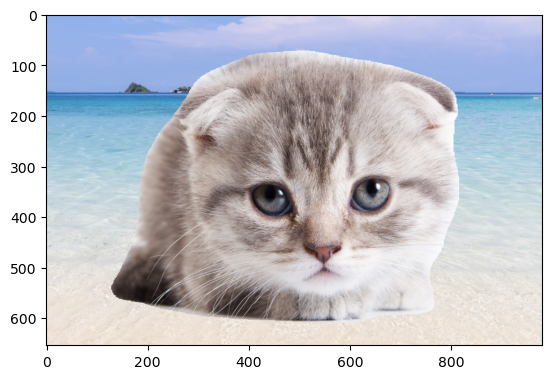

In [25]:
new_bg_path = "new_bg.jpg"  # 바꿀 배경 이미지 파일
new_bg_img = cv2.imread(new_bg_path)

# BGR -> RGB
new_bg_img = cv2.cvtColor(new_bg_img, cv2.COLOR_BGR2RGB)

# 배경을 고양이 이미지 크기에 맞춤 (W, H 순서 주의)
new_bg_resized = cv2.resize(new_bg_img, (cat_img.shape[1], cat_img.shape[0]))

# 마스크를 3채널로 변환
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# 고양이 부분만 남기고 새 배경 적용
result_img = np.where(img_mask_color == 255, cat_img, new_bg_resized)

plt.imshow(result_img)
plt.show()